In [8]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
from matplotlib import ticker

# load the results from no feature selection
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_NAVG_huge_nofeats.p", "rb"))

# process metrics
metrics_df = data_dic["metrics"]
metrics_df = metrics_df.round(2)
metrics_df = metrics_df.set_index("split")
metrics_df

# process predictions
predictions_df = data_dic["predictions_df"]
predictions_df.Split.unique()
predictions_df["Split"] = predictions_df["Split"].str.replace("Test", "Validation")
predictions_df["diff"] = predictions_df["predictions"] -  predictions_df["observed"]
predictions_df["diff_abs"] = np.abs(predictions_df["predictions"] -  predictions_df["observed"])
predictions_df["Split"] = [f"{i} ({metrics_df.loc[i]['pearsonr']})" for i in predictions_df["Split"]]
predictions_df_TV = predictions_df[~predictions_df["Split"].str.contains("DX")]

#cv data
df_cv = data_dic["summary_gs"]
df_cv = df_cv.sort_values("rank_test_score", ascending=True)
df_cv.filter(regex="param|rank", axis=1).head(20)
best_df = df_cv.filter(regex="split|rank")
best_df = pd.DataFrame(best_df[best_df["rank_test_score"] == 1].iloc[0]).transpose()

res_melt = best_df.melt(id_vars=["rank_test_score"])
res_melt["Split"] = ["Train" if "train" in i else "Test" for i in res_melt["variable"]]

In [10]:
print("Loading model, train, val, dx features and best features")
# model
model = data_dic["xgb"]
print(data_dic["data"].keys())

# data consists of tuples with meta data and feature data
all_data = data_dic["data"]
TT_train, TT_train_features, TT_predictions = all_data["TT_train"]
TT_val, TT_val_features, TT_val_predictions = all_data["TT_val"]
DX = all_data["DX"]

# use shortcut
features = data_dic["best_features_gs"]
X = TT_val_features[features]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_values_inter = shap.TreeExplainer(model).shap_interaction_values(X)

Loading model, train, val, dx features and best features
dict_keys(['TT_train', 'TT_val', 'DX'])


In [11]:
train_cv_col = "#6baed6"
test_col = "#bdd7e7"

# 80%20 splits
val_col = "C1"
train_col = "#2171b5"
# Train, Validation order for plotting
order_cor = predictions_df_TV["Split"].unique()

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


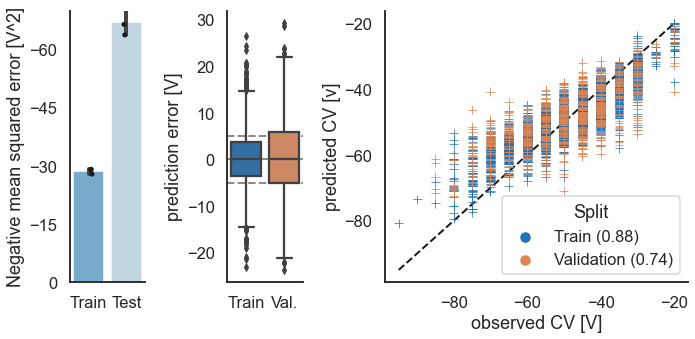

In [12]:
sns.set(style="white", context="talk")
gridspec_kw={'width_ratios':[0.25, 0.25,  1]}
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw=gridspec_kw)

# bar plot
ax0 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["Train", "Test"], palette={"Train": train_cv_col, "Test": test_col})
ax0 = sns.stripplot(x="Split", y="value", data=res_melt, ax=ax0, order=["Train", "Test"], color="k")
ax0.set_ylim(0, -70)
ax0.set(xlabel="", ylabel="Negative mean squared error [V^2]")
ax0.yaxis.set_major_locator(ticker.MaxNLocator(5))

# boxplot
ax1 = sns.boxplot(x="Split", y="diff", data=predictions_df_TV, ax=ax1,
                  palette={order_cor[0]: train_col, order_cor[1]: val_col})
ax1.axhline(0, lw=2, c="k", zorder=-1, alpha=0.5)
ax1.set(xlabel="", xticklabels=["Train", "Val."], ylabel="prediction error [V]")
ax1.axhline(5, lw=2, c="k", ls="--", zorder=-1, alpha=0.5)
ax1.axhline(-5, lw=2, c="k", ls="--", zorder=-1, alpha=0.5)

ax2 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df_TV,
                      marker="+", s=80, ax=ax2,
                      palette={order_cor[0]: train_col, order_cor[1]: val_col})
xmin = predictions_df_TV[["predictions", "observed"]].min().min()
xmax = predictions_df_TV[["predictions", "observed"]].max().max()
ax2.plot([xmin, xmax], [xmin, xmax], ls="--", zorder=-1, lw=2, c="k")
ax2.set(xlabel="observed CV [V]", ylabel="predicted CV [v]")
ax2.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax2.xaxis.set_major_locator(ticker.MaxNLocator(5))

for ax, letter in zip([ax0, ax1, ax2], list("abcde")):
    # ax.text(-0.1, 1.15, letter, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top',
    #          ha='right')
    sns.despine(ax=ax)
plt.tight_layout()
plt.show()

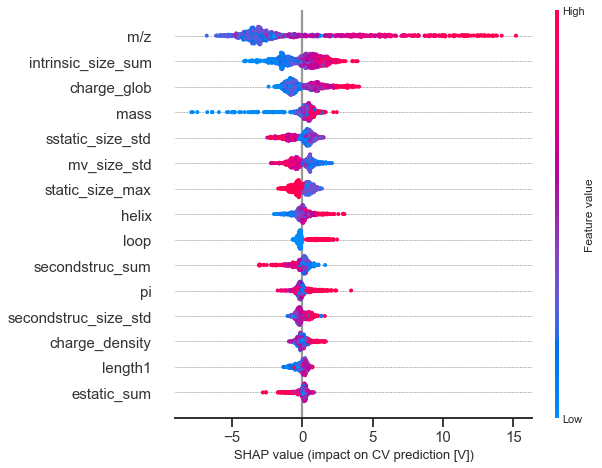

<Figure size 432x288 with 0 Axes>

In [13]:
shap.summary_plot(shap_values, X, show=False, max_display=15)
ax2 = plt.gca()
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
for i in range(0, 15):
    ax2.axhline(i, ls="--", lw=0.5, color="grey")
ax2.set(xlabel="SHAP value (impact on CV prediction [V])")
plt.show()
plt.clf()

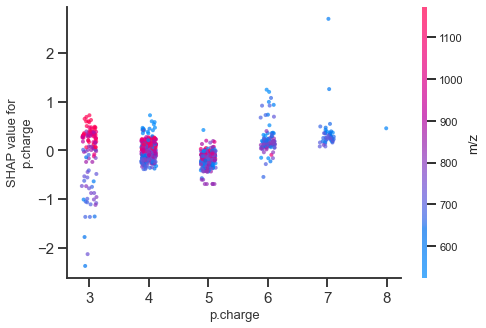

In [14]:
shap.dependence_plot("p.charge", shap_values, X, show=False, interaction_index="m/z",
                     x_jitter=0.25, alpha=0.7)
ax2 = plt.gca()
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

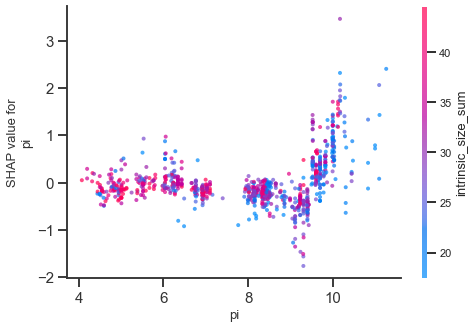

In [15]:
shap.dependence_plot("pi", shap_values, X, show=False, interaction_index="intrinsic_size_sum",
                     x_jitter=0.1, alpha=0.7)
ax2 = plt.gca()
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

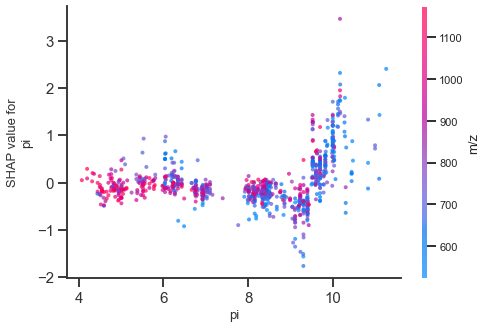

In [16]:
shap.dependence_plot("pi", shap_values, X, show=False, interaction_index="m/z",
                     x_jitter=0.1, alpha=0.7)
ax2 = plt.gca()
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)